# Explainability

In [ ]:
import medmnist
from medmnist.info import INFO
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import requests
from PIL import Image

data_flag_2d = 'breastmnist' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_2d] # INFO is embedded in the medmnist containing basic information of datasets
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [ ]:
# preprocessing such as conversion to tensor and normalization
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# get the data class
DataClass = getattr(medmnist, info['python_class'])

# encapsulate datasets into Dataloader form
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=True)

label: [0]


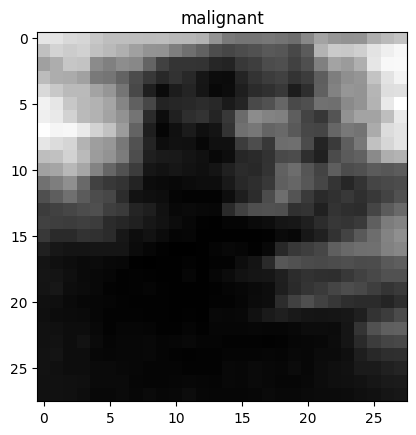

In [3]:
img, label = test_dataset[0]
label_text = test_dataset.info['label'][f'{label.item()}']

print(f'label: {label}')
plt.title(label_text)
plt.imshow(img.squeeze(), cmap='gray')

In [4]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.0)
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = CNN(n_channels,1)

# Training with GradCAM

Train Epoch: 1 Loss: 0.806956 Validation loss: 0.682874 Acc: nan 
Grad-cam testing
The confidence increase percent: 0.48763155937194824
Train Epoch: 2 Loss: 0.429529 Validation loss: 0.607375 Acc: nan 
Grad-cam testing
The confidence increase percent: 2.0984113216400146
Train Epoch: 3 Loss: 0.394347 Validation loss: 0.580428 Acc: nan 
Grad-cam testing
The confidence increase percent: 7.380551099777222
Train Epoch: 4 Loss: 0.386583 Validation loss: 0.589992 Acc: nan 
Grad-cam testing
The confidence increase percent: 17.102837562561035
Train Epoch: 5 Loss: 0.373453 Validation loss: 0.684977 Acc: nan 
Grad-cam testing
The confidence increase percent: 26.36478543281555
Train Epoch: 6 Loss: 0.427280 Validation loss: 0.579797 Acc: nan 
Grad-cam testing
The confidence increase percent: 16.372150182724
Train Epoch: 7 Loss: 0.382041 Validation loss: 0.560203 Acc: nan 
Grad-cam testing
The confidence increase percent: 26.501494646072388
Train Epoch: 8 Loss: 0.364302 Validation loss: 0.625809 Acc

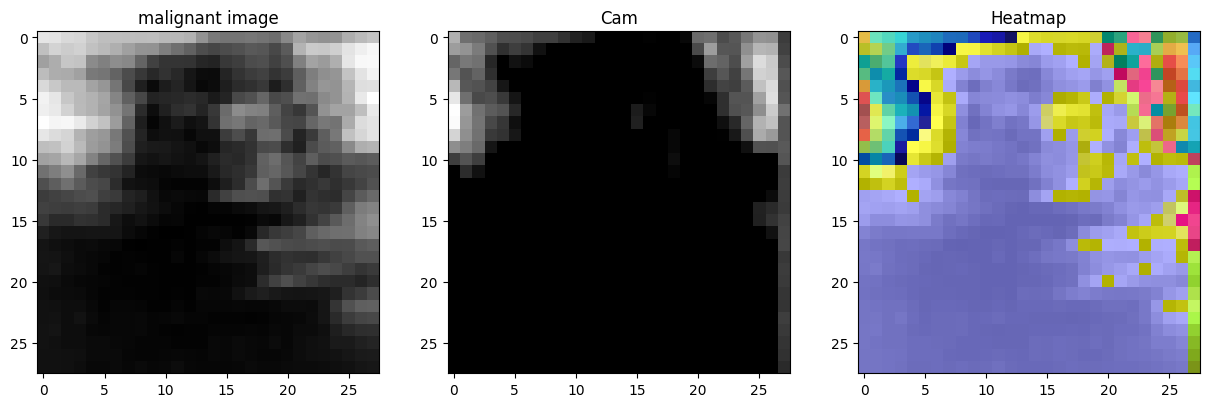

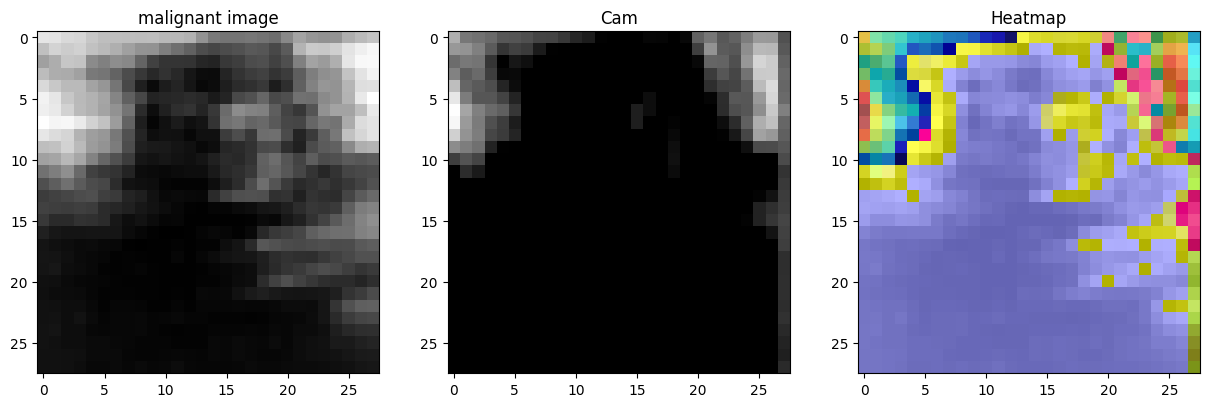

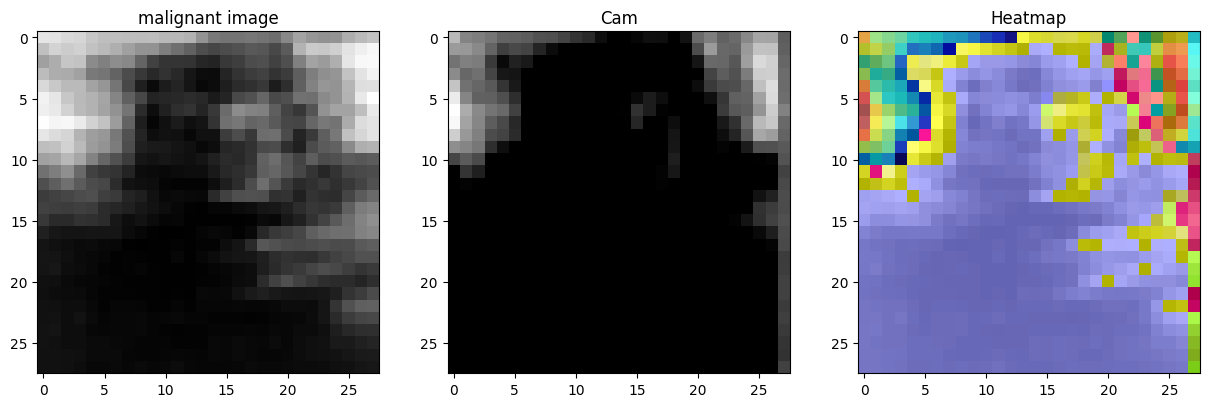

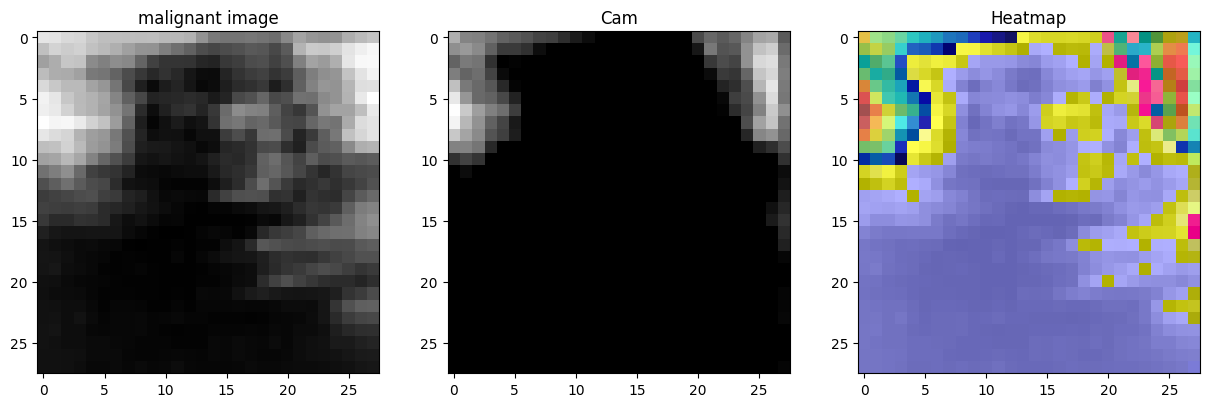

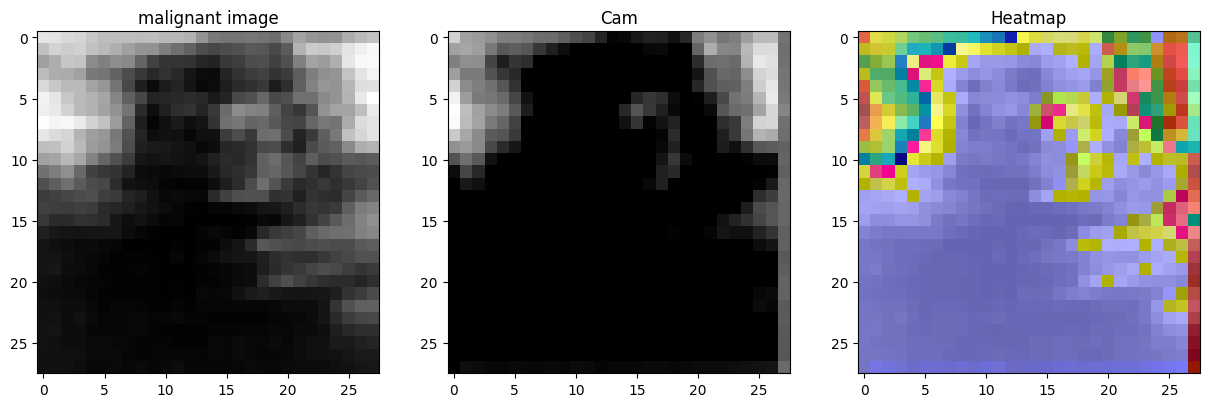

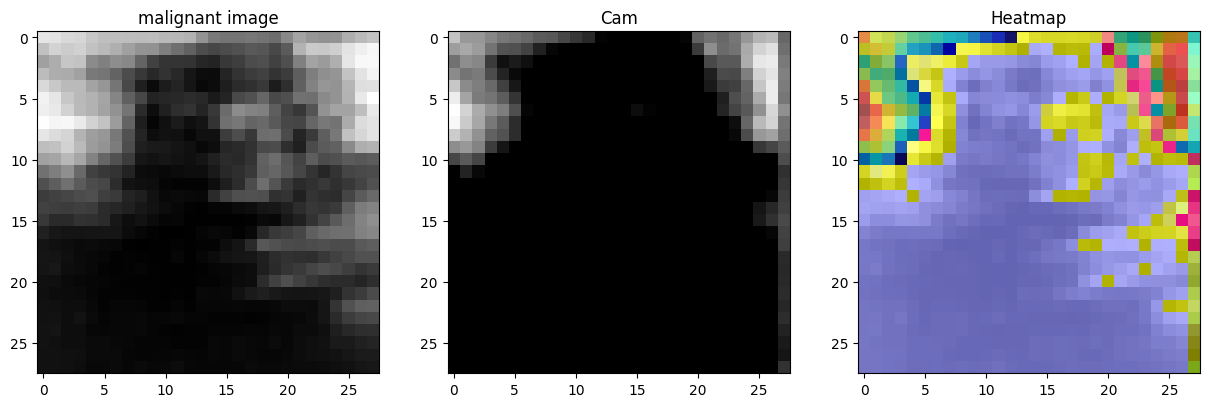

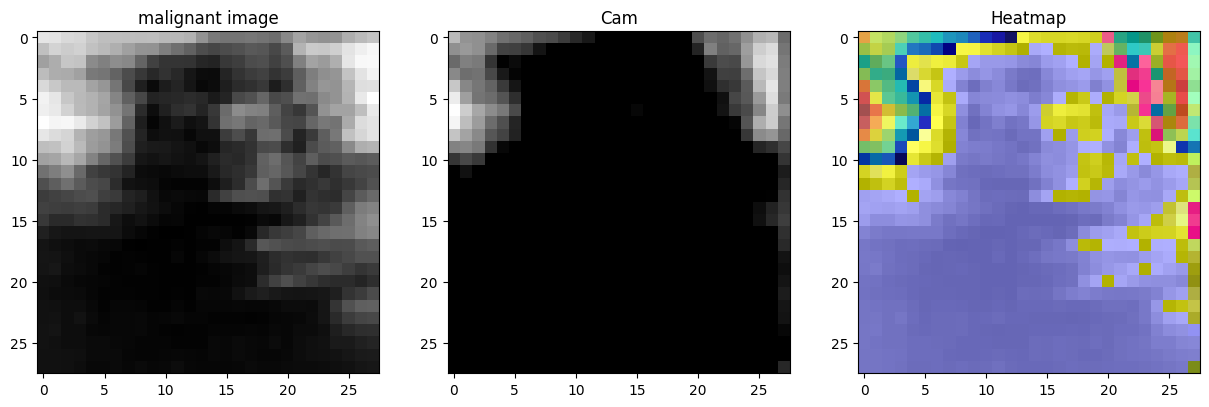

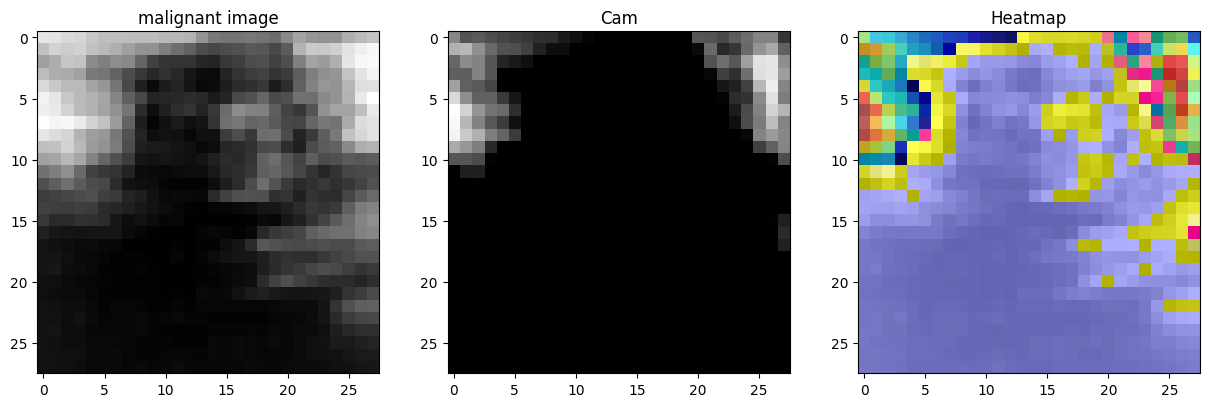

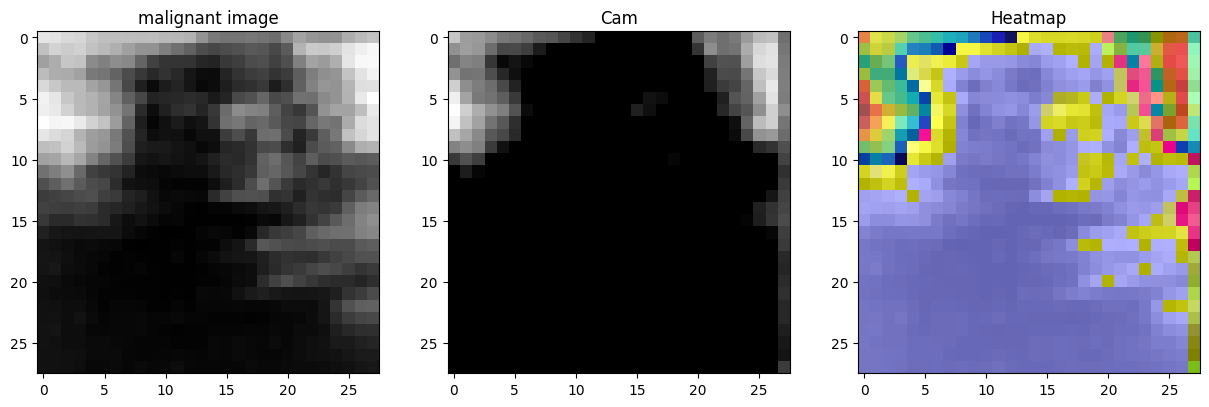

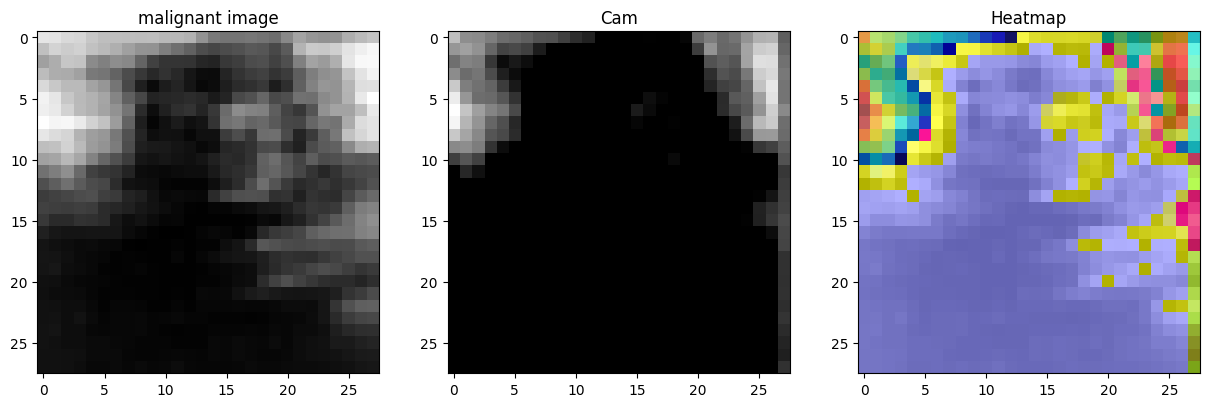

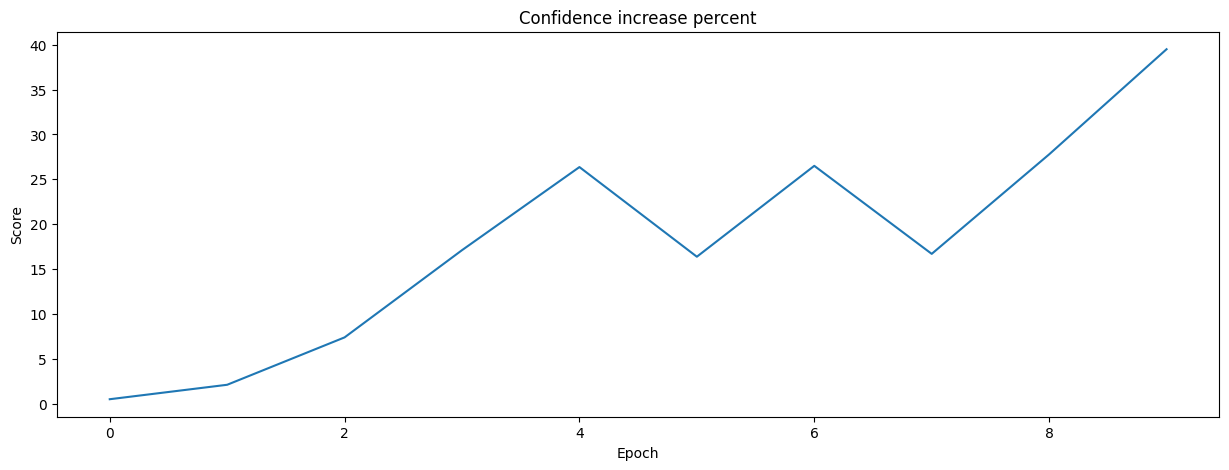

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import cv2

img, label = test_dataset[0]
label_text = test_dataset.info['label'][f'{label.item()}']

targets = [ClassifierOutputTarget(0)]
target_layers = [model.conv5]
input_tensor = torch.unsqueeze(img, 0)

def train(device, model, train_loader, epochs, learning_rate):
    model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()
    scores_graph = []


    for epoch in range(epochs):
        losses = []
        valid_losses = []
        train_loss = 0.0


        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float()).squeeze()
            loss = criterion(outputs, labels.float().squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            losses.append(train_loss/len(train_loader.dataset))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.float()).squeeze()
                loss = criterion(outputs, labels.float().squeeze())
                val_loss += loss.item() * inputs.size(0)
                valid_losses.append(val_loss/len(val_loader.dataset))



        # We suggest you modify this code to run the continuous explanations
        print(
                f"Train Epoch: {epoch + 1} "
                f"Loss: {np.mean(losses):.6f} "
                f"Validation loss: {np.mean(valid_losses):.6f} "
            )
        print(f"Grad-cam testing")
        target_layers = [model.conv1]
        with GradCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            cam_metric = CamMultImageConfidenceChange()
            scores, _ = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
            score = scores[0]
            scores_graph.append(100*score)
            
            print(f"The confidence increase percent: {100*score}")

            reversed_img = img.squeeze().numpy()
            reversed_img = reversed_img[:,:, np.newaxis]
            cam_image = show_cam_on_image(reversed_img, grayscale_cams[0, :], use_rgb=True)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        cam = np.uint8(255 * grayscale_cams[0, :])
        cam = cv2.merge([cam, cam, cam])

        axes[0].imshow(img.squeeze(), cmap='gray')
        axes[0].set_title(label_text+' image')

        axes[1].imshow(cam)
        axes[1].set_title('Cam')

        axes[2].imshow(cam_image)
        axes[2].set_title('Heatmap')

        fig.savefig(f'./breast_cancer/Epoch_{epoch}.png')

    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    axes.set_title('Confidence increase percent')
    axes.set_ylabel('Score')
    axes.set_xlabel('Epoch')
    axes.plot(scores_graph)
    fig.savefig(f'./breast_cancer/Confidence_increase.png')
    return model

model = CNN(n_channels,1)
model = train('cpu', model, train_loader, 10, 0.001)

model prediction: Malignant


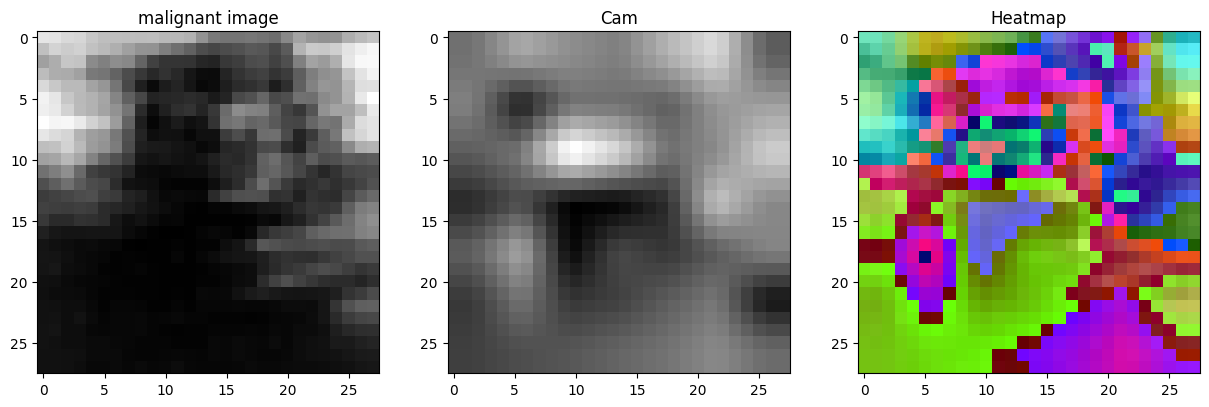

In [7]:
img, label = test_dataset[0]
label_text = test_dataset.info['label'][f'{label.item()}']

pretrained_model = CNN(n_channels,1)
pretrained_model.load_state_dict(torch.load('cnn_model.pt'))
pretrained_model.eval()

targets = [ClassifierOutputTarget(0)]
target_layers = [pretrained_model.conv5]
input_tensor = torch.unsqueeze(img, 0)


with GradCAM(model=pretrained_model, target_layers=target_layers) as gcam:
    grayscale_cam = gcam(input_tensor=input_tensor, targets=targets)
    reversed_img = img.squeeze().numpy()
    reversed_img = reversed_img[:,:, np.newaxis]
    cam_image = show_cam_on_image(reversed_img, grayscale_cam[0, :], use_rgb=True)

cam = np.uint8(255 * grayscale_cam[0, :])
cam = cv2.merge([cam, cam, cam])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img.squeeze(), cmap='gray')
axes[0].set_title(label_text+' image')

axes[1].imshow(cam)
axes[1].set_title('Cam')

axes[2].imshow(cam_image)
axes[2].set_title('Heatmap')
print('model prediction: ' + ('Benign' if pretrained_model(img.unsqueeze(0)).item() > 0.5 else 'Malignant'))

The confidence increase percentage is 37.057%
The visualization is: 


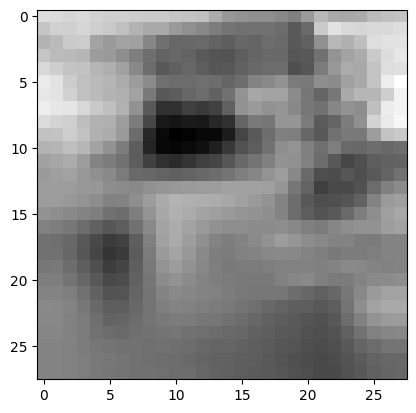

In [8]:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

targets = [ClassifierOutputTarget(0)]
cam_metric = CamMultImageConfidenceChange()
scores, visualization = cam_metric(input_tensor, grayscale_cam, targets, pretrained_model, return_visualization=True)
scores = scores[0]
visualization = visualization[0].cpu().numpy().transpose(1, 2, 0)
visualization = deprocess_image(visualization)
print(f'The confidence increase percentage is {scores*100:.3f}%')
print('The visualization is: ')

plt.imshow(visualization, cmap='gray')

100%|██████████| 8/8 [00:00<00:00, 25.58it/s]


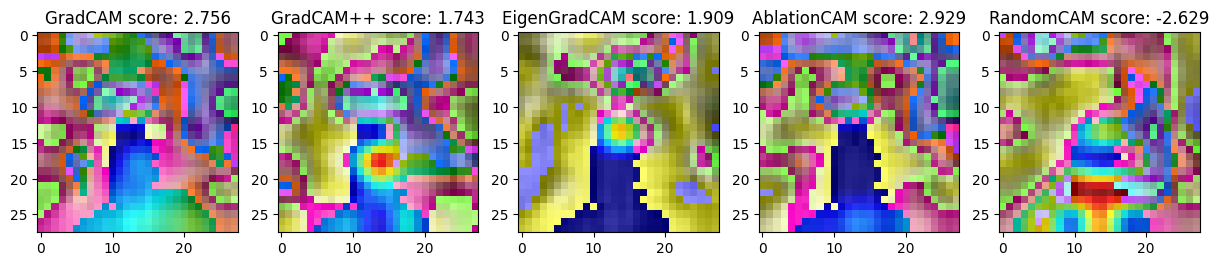

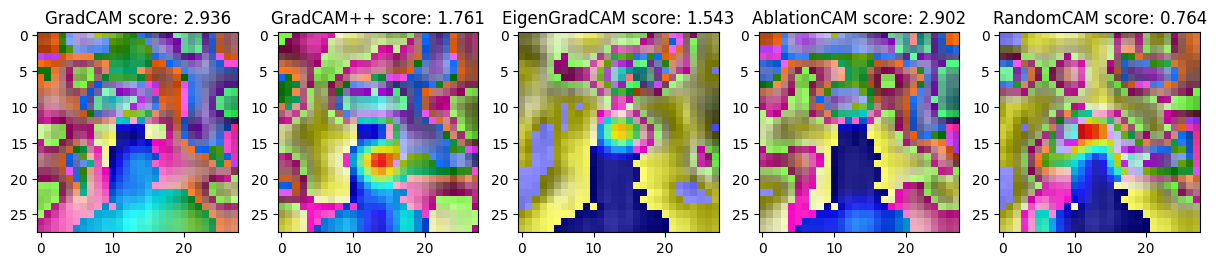

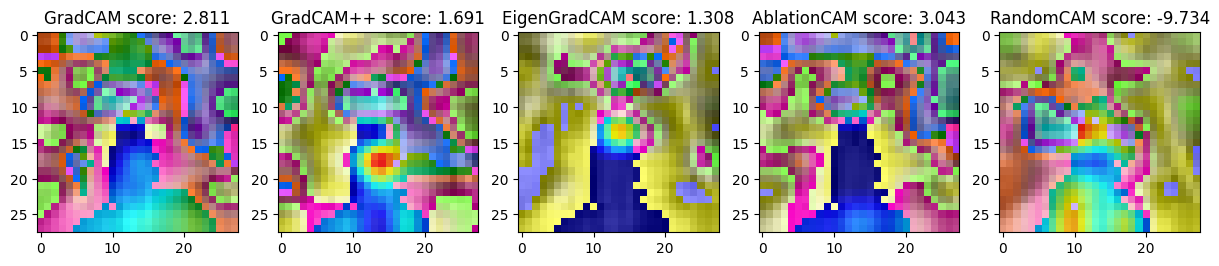

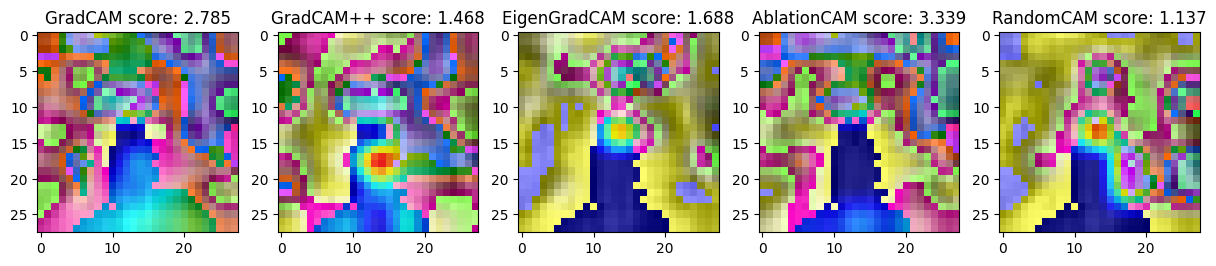

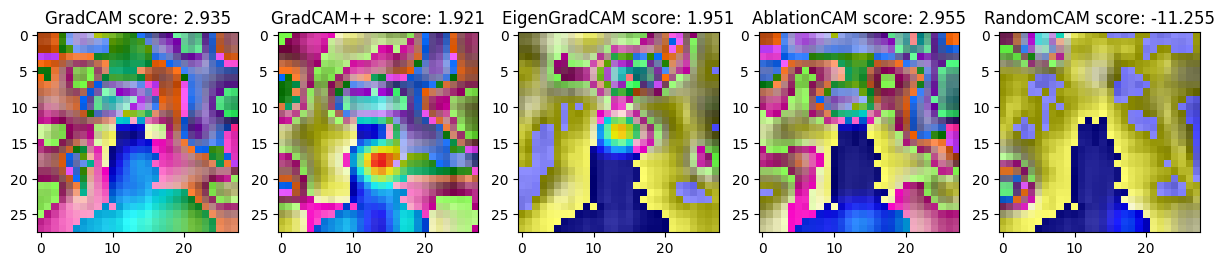

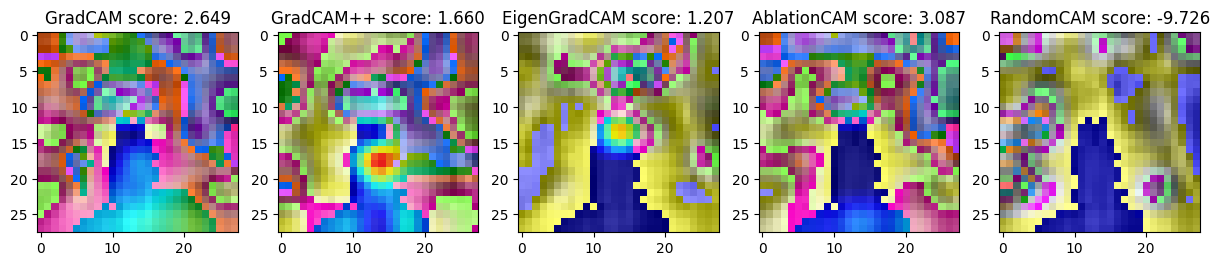

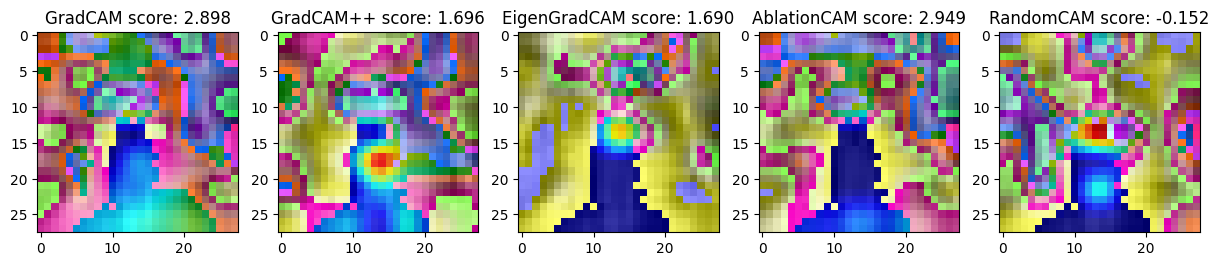

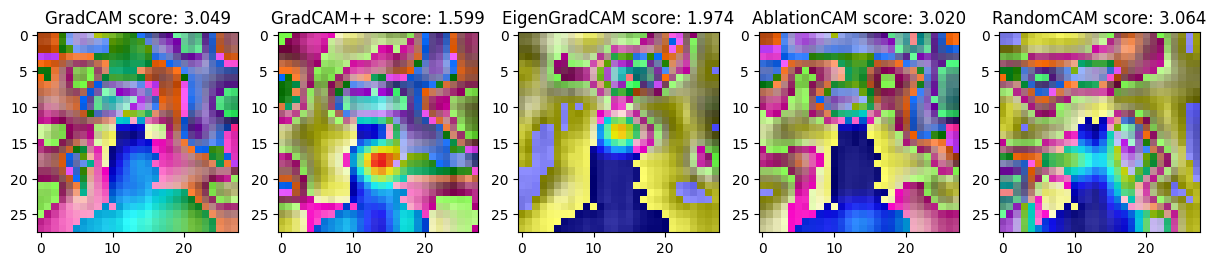

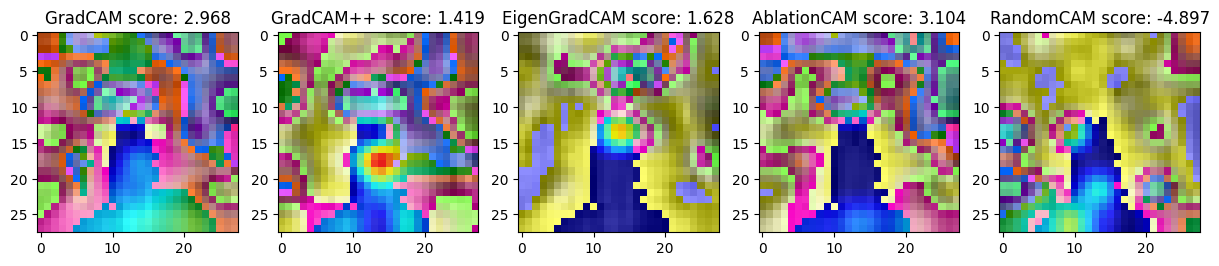

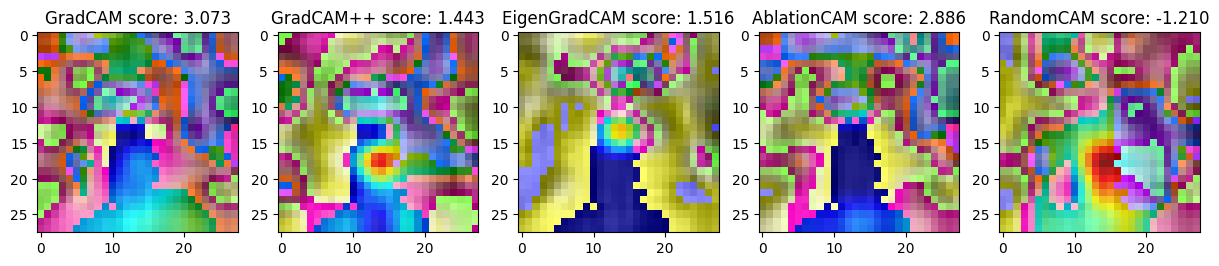

In [50]:
# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles, index, axes):
    axes[index].imshow(visualization)
    axes[index].set_title(f'{name} score: {score*100:.3f}')
    
    return visualization
    
def benchmark(input_tensor, model, target_layers,img, eigen_smooth=False, aug_smooth=False, category=0, score_graph=None, visualize=True, index=0):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputTarget(category)]
    
    percentiles = [10, 50, 90]

    if visualize:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))


    for i, (name, cam_method) in enumerate(methods):
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]        
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        if score_graph is not None:
            score_graph[name].append(score)

        if visualize:
            visualization = show_cam_on_image(img, attribution, use_rgb=True)
            visualize_score(visualization, score, name, percentiles,i, axes=axes)
    
    fig.savefig(f'./GradCamEvaluation/breast_cancer_cnn/GCAM_Comparison_{index}.png')

np.random.seed(42)
score_graph = {"GradCAM": [], "GradCAM++": [], "EigenGradCAM": [], "AblationCAM": [], "RandomCAM": []}
for i in range(10):
    benchmark(input_tensor, pretrained_model, target_layers, reversed_img, eigen_smooth=False, aug_smooth=False, category=0, visualize=True, index=i)


In [ ]:
data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])

# load the pneumonia data
train_dataset_pneumonia = DataClass_pneumonia(split='train', transform=data_transform, download=download)
test_dataset_pneumonia = DataClass_pneumonia(split='test', transform=data_transform, download=download)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)
print(info_pneumonia)

# encapsulate data into dataloader form
train_loader_pneumonia = torch.utils.data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
test_loader_pneumonia = torch.utils.data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

In [12]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.fc = nn.Sequential(
            nn.Linear(128*4, num_classes)
        )
        
        self.extract_embeddings = False

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        if self.extract_embeddings:
            # Return the output of layer4 as embeddings
            return x.view(x.size(0), -1)
            
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

100%|██████████| 74/74 [00:02<00:00, 30.93it/s]


Epoch: 1	Loss: 0.2143
Grad-cam testing
The confidence increase percent: -0.18325960263609886


100%|██████████| 74/74 [00:02<00:00, 29.43it/s]


Epoch: 2	Loss: 0.1017
Grad-cam testing
The confidence increase percent: 7.158822566270828


100%|██████████| 74/74 [00:02<00:00, 28.39it/s]


Epoch: 3	Loss: 0.0761
Grad-cam testing
The confidence increase percent: 14.276041090488434


100%|██████████| 74/74 [00:02<00:00, 24.90it/s]


Epoch: 4	Loss: 0.0604
Grad-cam testing
The confidence increase percent: -0.27251190040260553


100%|██████████| 74/74 [00:02<00:00, 31.97it/s]


Epoch: 5	Loss: 0.0463
Grad-cam testing
The confidence increase percent: -0.04443326033651829


100%|██████████| 74/74 [00:02<00:00, 32.95it/s]


Epoch: 6	Loss: 0.0386
Grad-cam testing
The confidence increase percent: -0.11154654202982783


100%|██████████| 74/74 [00:02<00:00, 32.36it/s]


Epoch: 7	Loss: 0.0286
Grad-cam testing
The confidence increase percent: -0.15161539195105433


100%|██████████| 74/74 [00:02<00:00, 30.79it/s]


Epoch: 8	Loss: 0.0227
Grad-cam testing
The confidence increase percent: 2.0584341138601303


100%|██████████| 74/74 [00:02<00:00, 33.44it/s]


Epoch: 9	Loss: 0.0193
Grad-cam testing
The confidence increase percent: -0.048007769510149956


100%|██████████| 74/74 [00:02<00:00, 32.23it/s]


Epoch: 10	Loss: 0.0172
Grad-cam testing
The confidence increase percent: 2.197793871164322


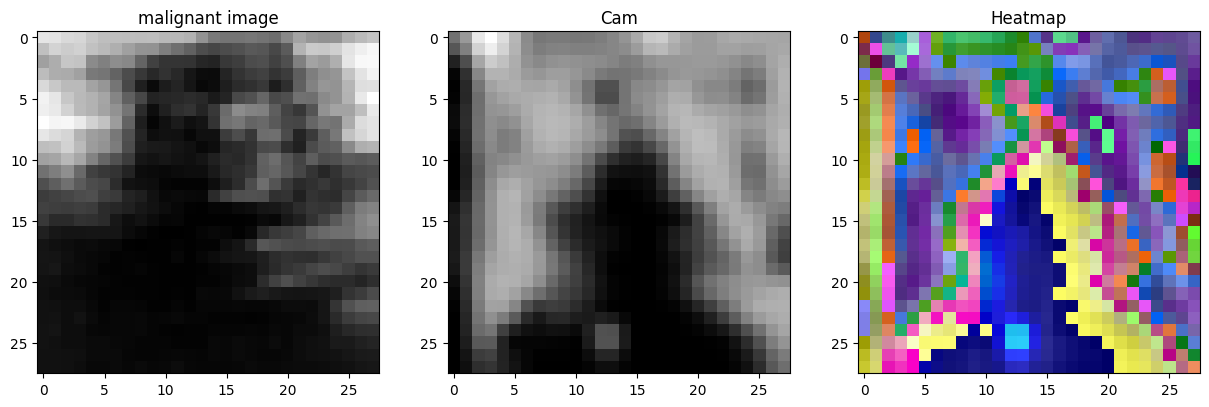

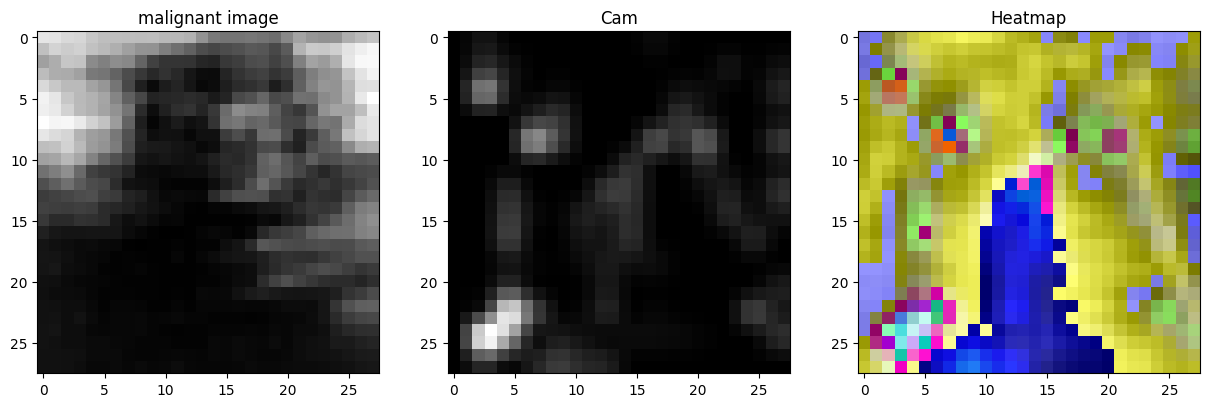

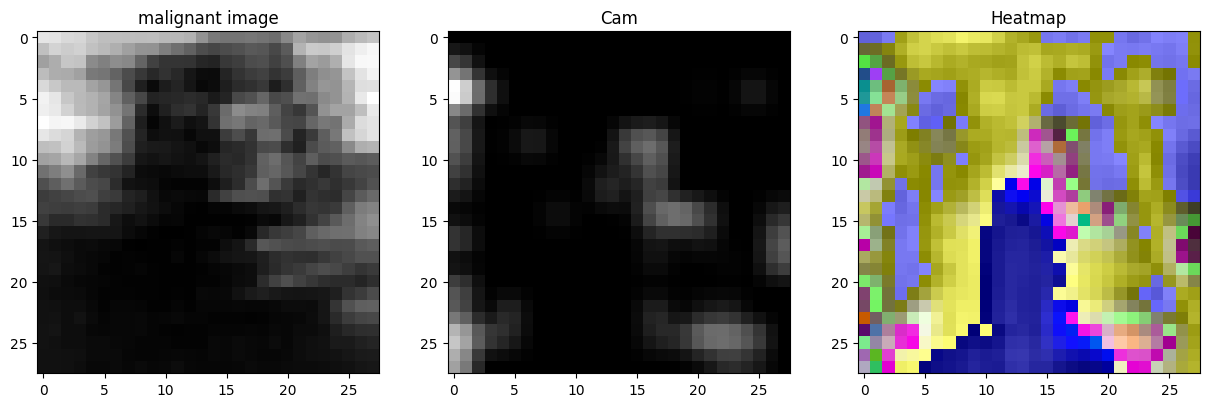

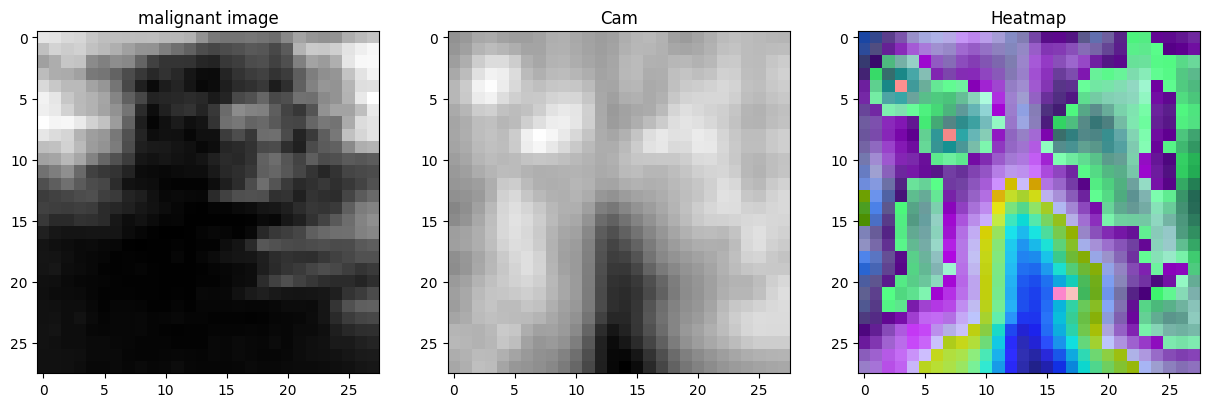

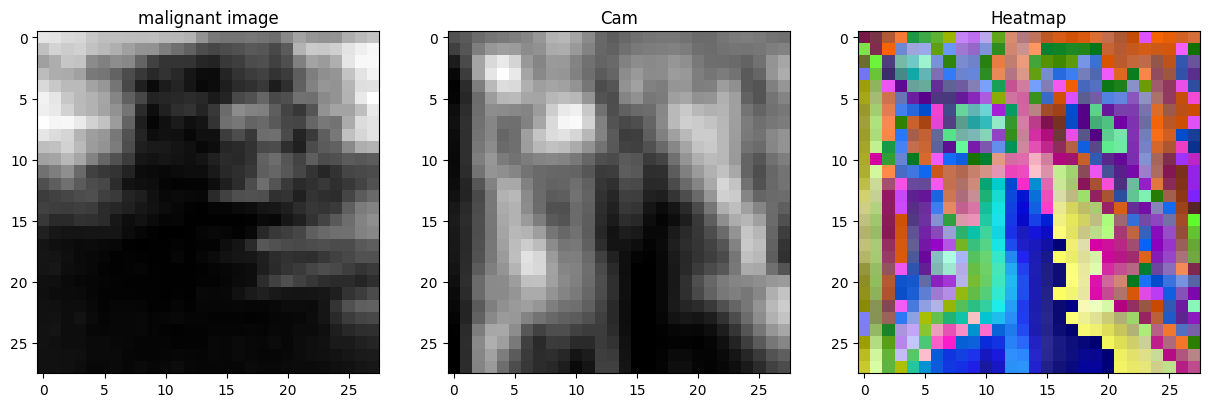

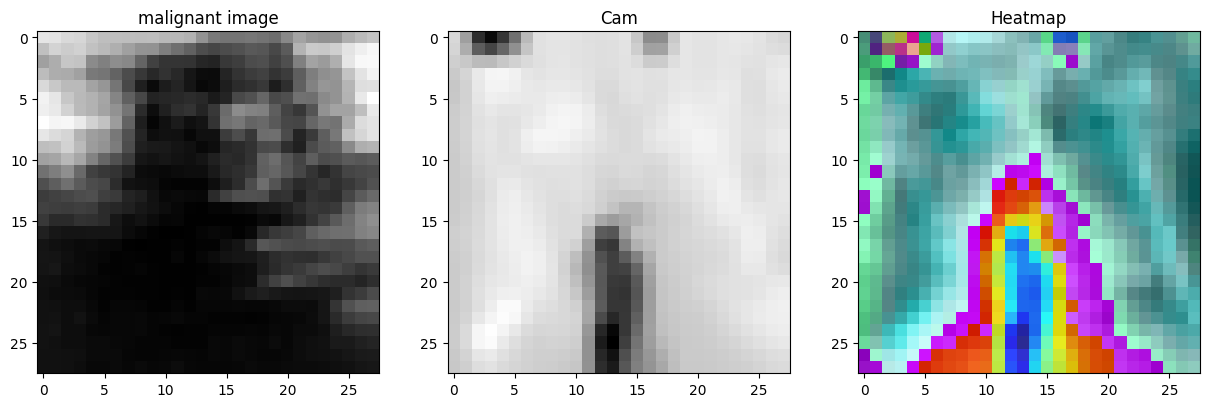

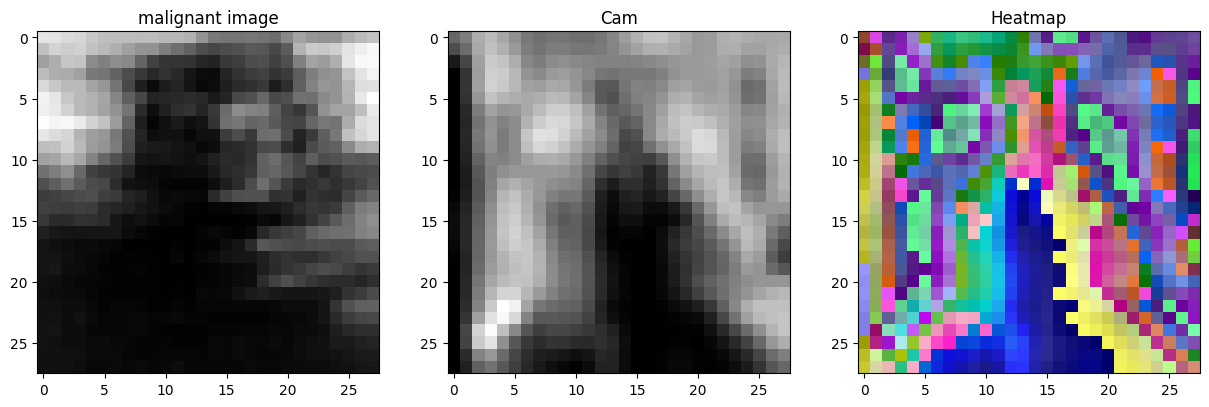

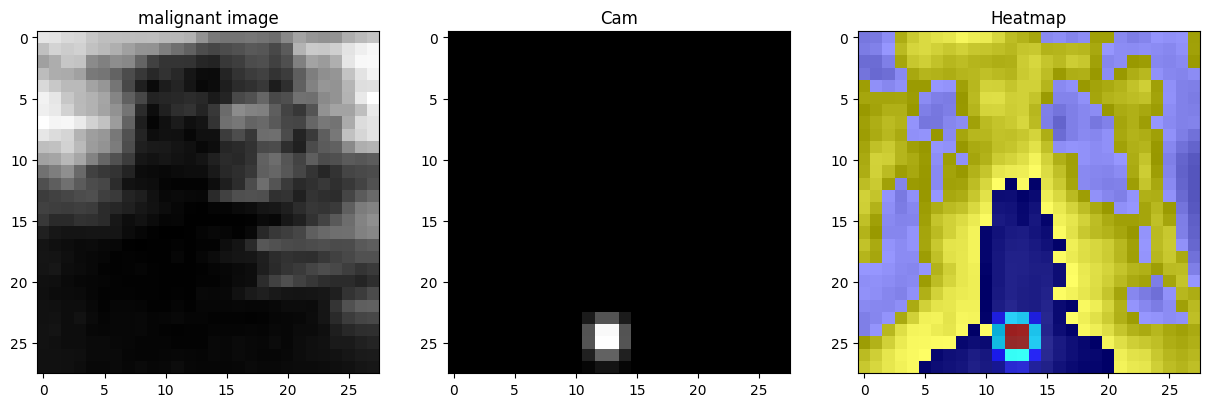

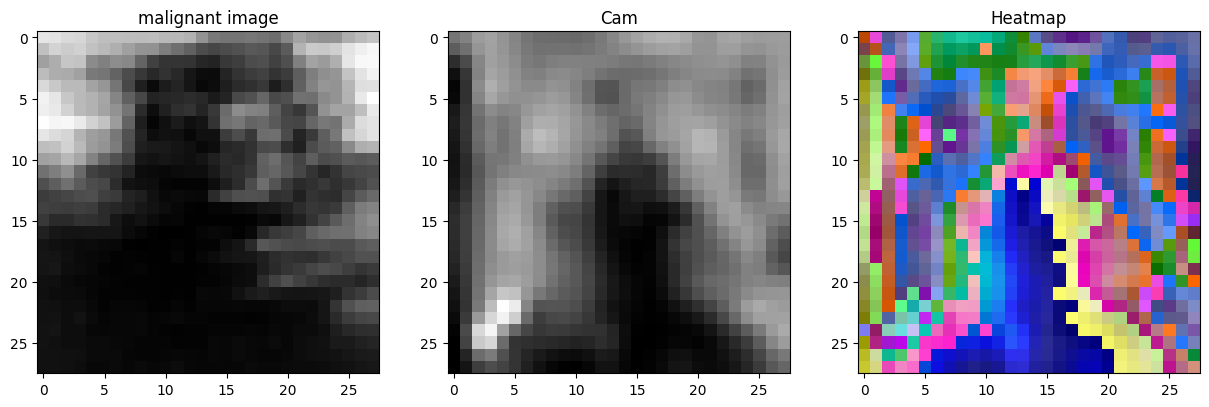

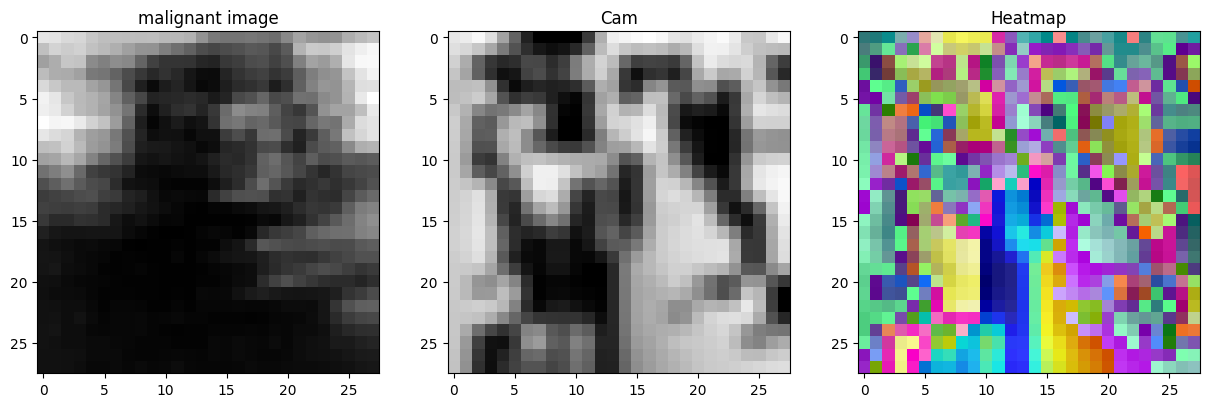

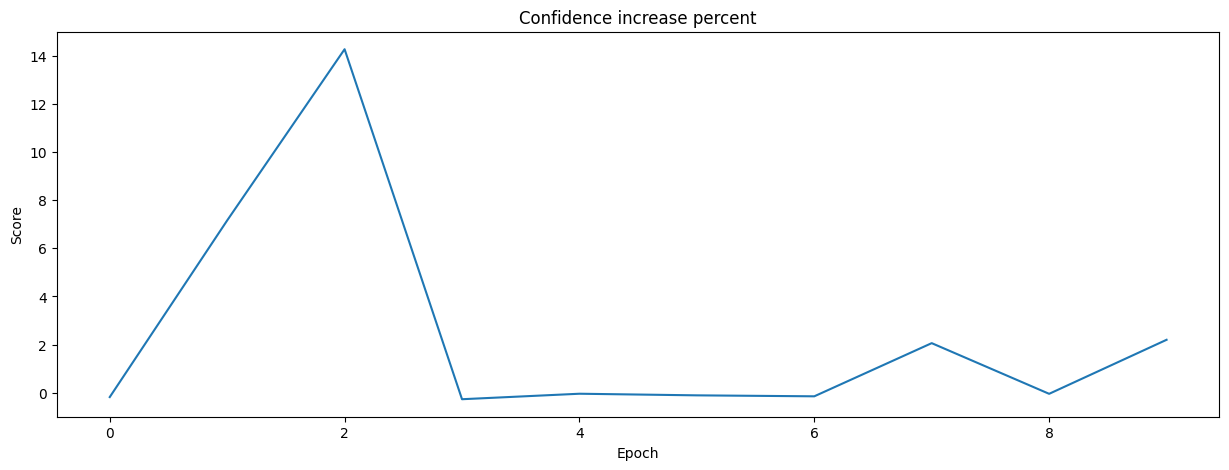

In [77]:
model_pneumonia = Net(in_channels=n_channels_pneumonia, num_classes=2)
optimizer_pneumonia = optim.SGD(model_pneumonia.parameters(), lr=0.001, momentum=0.9)

img_pneumonia, label_pneumonia = test_dataset_pneumonia[i]
label_text_pneumonia = test_dataset_pneumonia.info['label'][f'{label_pneumonia.item()}']

targets_pneumonia = [ClassifierOutputTarget(1)]
target_layers_pneumonia = [model_pneumonia.layer4]
input_tensor_pneumonia = torch.unsqueeze(img_pneumonia, 0)

def train_pneumonia(model, loader, optimizer, convert_to_binary, epochs, device):
    criterion_ce = nn.CrossEntropyLoss()
    scores_graph = []
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            # forward + backward + optimize
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.squeeze().long()

            if convert_to_binary:
                outputs = torch.sigmoid(outputs)
                targets_binary = torch.zeros(targets.shape[0], 2)
                targets_binary[:, 0] = (targets.sum(dim=1) == 0).long()
                targets_binary[:, 1] = (targets.sum(dim=1) > 0).long()
                targets = targets_binary
                              
            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()

            loss.backward()
            optimizer.step()
        
        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch+1, avg_loss))
        print(f"Grad-cam testing")
        targets = [ClassifierOutputTarget(0)]
        metric_targets = [ClassifierOutputSoftmaxTarget(0)]
        target_layers = [model.layer1]
        with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
            grayscale_cams = cam(input_tensor=input_tensor_pneumonia, targets=targets)
            cam_metric = CamMultImageConfidenceChange()
            scores, _ = cam_metric(input_tensor_pneumonia, grayscale_cams, metric_targets, model, return_visualization=True)
            score = scores[0]
            scores_graph.append(100*score)
            
            print(f"The confidence increase percent: {100*score}")

            reversed_img = img_pneumonia.squeeze().numpy()
            reversed_img = reversed_img[:,:, np.newaxis]
            cam_image = show_cam_on_image(reversed_img, grayscale_cams[0, :], use_rgb=True)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        cam = np.uint8(255 * grayscale_cams[0, :])
        cam = cv2.merge([cam, cam, cam])

        axes[0].imshow(img.squeeze(), cmap='gray')
        axes[0].set_title(label_text+' image')

        axes[1].imshow(cam)
        axes[1].set_title('Cam')

        axes[2].imshow(cam_image)
        axes[2].set_title('Heatmap')
        fig.savefig(f'./pneumonia/Epoch_{epoch}.png')

    
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    axes.set_title('Confidence increase percent')
    axes.set_ylabel('Score')
    axes.set_xlabel('Epoch')
    axes.plot(scores_graph)
    fig.savefig(f'./pneumonia/Confidence_increase.png')

    return model

model_pneumonia = train_pneumonia(model_pneumonia, train_loader_pneumonia, optimizer_pneumonia, convert_to_binary=False, epochs=10, device='cpu')

model prediction: Pneumonia


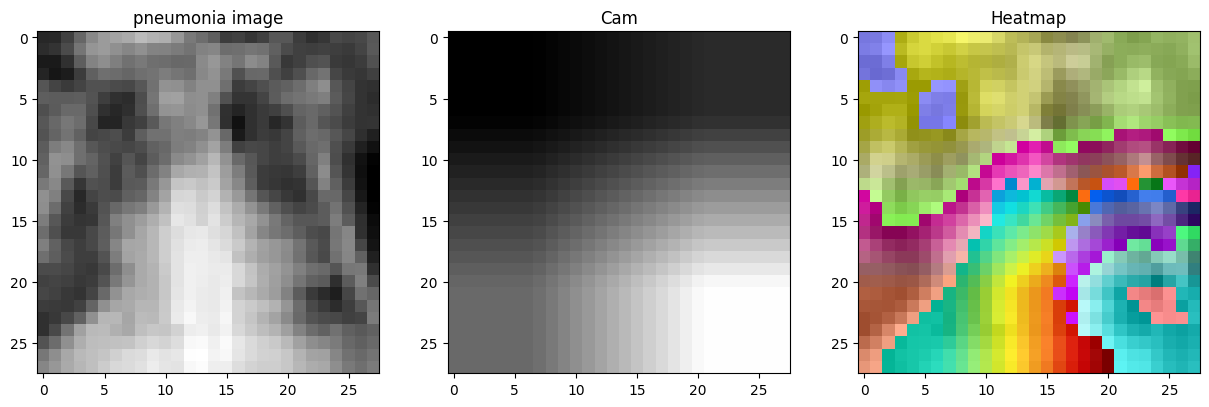

In [62]:
img_pneumonia, label_pneumonia = test_dataset_pneumonia[i]
label_text_pneumonia = test_dataset_pneumonia.info['label'][f'{label_pneumonia.item()}']

targets_pneumonia = [ClassifierOutputTarget(1)]
target_layers_pneumonia = [model_pneumonia.layer4]
input_tensor_pneumonia = torch.unsqueeze(img_pneumonia, 0)

model_pneumonia.eval()

with GradCAM(model=model_pneumonia, target_layers=target_layers_pneumonia) as gcam:
    grayscale_cam = gcam(input_tensor=input_tensor_pneumonia, targets=targets_pneumonia)
    reversed_img = img_pneumonia.squeeze().numpy()
    reversed_img = reversed_img[:,:, np.newaxis]
    cam_image = show_cam_on_image(reversed_img, grayscale_cam[0, :], use_rgb=True)

cam = np.uint8(255 * grayscale_cam[0, :])
cam = cv2.merge([cam, cam, cam])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_pneumonia.squeeze(), cmap='gray')
axes[0].set_title(label_text_pneumonia+' image')

axes[1].imshow(cam)
axes[1].set_title('Cam')

axes[2].imshow(cam_image)
axes[2].set_title('Heatmap')
print('model prediction: ' + ('Normal' if torch.argmax(model_pneumonia(img_pneumonia.unsqueeze(0))) == 0 else 'Pneumonia'))

100%|██████████| 4/4 [00:00<00:00, 137.24it/s]


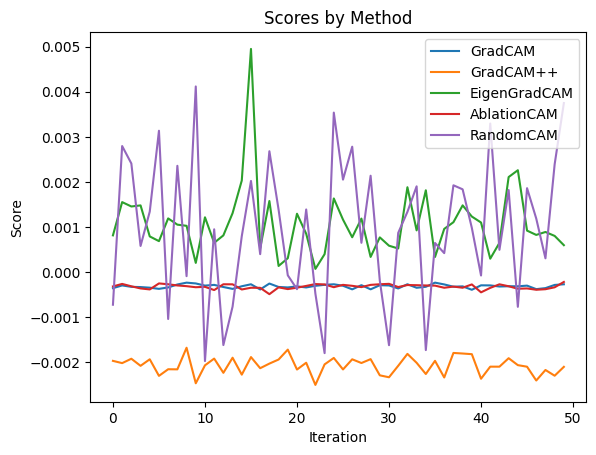

In [55]:
def benchmark_pneumonia(input_tensor, model, target_layers,img, eigen_smooth=False, aug_smooth=False, category=0, score_graph=None, visualize=True, index=0):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    percentiles = [10, 50, 90]

    if visualize:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))


    for i, (name, cam_method) in enumerate(methods):
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]        
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        if score_graph is not None:
            score_graph[name].append(score)

        if visualize:
            visualization = show_cam_on_image(img, attribution, use_rgb=True)
            visualize_score(visualization, score, name, percentiles,i, axes=axes)
    
    #fig.savefig(f'./GradCamEvaluation/pneumonia_unet/GCAM_Comparison_{index}.png')

score_graph = {"GradCAM": [], "GradCAM++": [], "EigenGradCAM": [], "AblationCAM": [], "RandomCAM": []}
for i in range(50):
    benchmark_pneumonia(input_tensor_pneumonia, model_pneumonia, target_layers_pneumonia, reversed_img, eigen_smooth=False, aug_smooth=False, category=1, visualize=False, index=i, score_graph=score_graph)

for method, values in score_graph.items():
    plt.plot(values, label=method)

plt.legend()
plt.title("Scores by Method")
plt.xlabel("Iteration")
plt.ylabel("Score")

plt.show()